In [1]:
%cd ../code

/home/chickencurry/markup-ocr/experiments/seq2seq/encoder-decoder/code


In [2]:
from data import LatexEquationDataset, create_tokenizer, load_tokenizer, load_img_names_to_skip, curry_collate_fn, clean, get_input_token_ids, get_target_token_ids
from model import EncoderDecoder
from eval import get_bleu, print_statistics

import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, random_split
from torchmetrics import CharErrorRate, WordErrorRate, BLEUScore
from matplotlib import pyplot as plt
from tqdm import tqdm

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cpu"

In [4]:
import torch_directml
device = torch_directml.device()

In [5]:
img_test_dir = "../data/formulae/test"
img_train_dir = "../data/formulae/train"
img_val_dir = "../data/formulae/val"
equations_path = "../data/formulae/math.txt"
tokenizer_path = "../data/test_tokenizer.json"
img_names_to_skip_dir = "../data/img_names_to_skip"

In [6]:
# create_tokenizer(equations_path, tokenizer_path)
tokenizer = load_tokenizer(tokenizer_path)

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# create_img_names_to_skip(img_train_dir, img_names_to_skip_dir)
img_names_to_skip = load_img_names_to_skip(img_names_to_skip_dir)

In [8]:
dataset = LatexEquationDataset(equations_path, img_train_dir, img_names_to_skip, tokenizer)
training_dataset, validation_dataset = random_split(dataset, [0.7, 0.3])

# training_dataset = LatexEquationDataset(equations_path, img_train_dir, img_names_to_skip, tokenizer)
# validation_dataset = LatexEquationDataset(equations_path, img_val_dir, img_names_to_skip, tokenizer)

training_dataloader = DataLoader(training_dataset, batch_size=10, shuffle=False, collate_fn=curry_collate_fn(tokenizer.convert_tokens_to_ids("[PAD]")))
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=curry_collate_fn(tokenizer.convert_tokens_to_ids("[PAD]")))

\Delta a = { \frac { 1 5 } { 2 } } \pi ^ { 2 } \int \mathrm { d } ^ { 4 } x \, | x | ^ { 4 } \, \langle \Theta ( x ) \, \Theta ( 0 ) \rangle


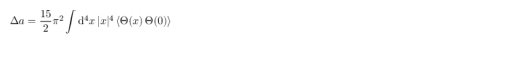

In [9]:
item = next(iter(training_dataloader))
tokens = tokenizer.convert_ids_to_tokens(item[1][0].tolist(), skip_special_tokens = True)
print(clean("".join(tokens)))

plt.figure()
plt.axis("off")
plt.imshow(item[0][0].squeeze(0), cmap="gray")
plt.show()

In [10]:
model = EncoderDecoder(
    vocab_size=tokenizer.vocab_size,
    d_feature=512,
    d_model=256,
    n_blocks_enc=4,
    n_blocks_dec=4,
    n_heads=8,
    d_hidden=1024,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids("[PAD]"), label_smoothing=0.1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
train_loss = []
num_epochs = 1

for epoch in range(num_epochs):
    
    model.train()
    torch.inference_mode(False)

    training_iterator = tqdm(training_dataloader, total=len(training_dataloader), desc="training epoch {}/{}".format(epoch, num_epochs))

    for img, token_ids in training_iterator:
        # move to GPU
        img = img.to(device)
        input_token_ids = get_input_token_ids(token_ids, tokenizer).to(device)
        target_token_ids = get_target_token_ids(token_ids, tokenizer).to(device)

        # forward
        logits = model(img, input_token_ids)
        loss = criterion(logits, target_token_ids)

        # collect stats
        train_loss.append(loss.item())
        training_iterator.set_postfix({"loss": f"{loss.item():.4f}"})

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
output_texts = []
target_texts = []

model.eval()
torch.inference_mode(True)

validation_iterator = tqdm(validation_dataloader, total=len(validation_dataloader), desc="validation epoch {}/{}".format(epoch, num_epochs))

for index, (img, token_ids) in tqdm(validation_dataloader):
    # move to GPU
    img = img.to(device)
    input_token_ids = get_input_token_ids(token_ids, tokenizer).to(device)
    target_token_ids = get_target_token_ids(token_ids, tokenizer).to(device)

    # forward
    logits = model(img, input_token_ids)
    
    # collect stats
    output_texts.append(tokenizer.convert_ids_to_tokens(input_token_ids[0].tolist(), skip_special_tokens = True))
    target_texts.append(tokenizer.convert_ids_to_tokens(target_token_ids[0].tolist(), skip_special_tokens = True))

bleu = BLEUScore()(output_texts, target_texts)
wer = WordErrorRate()(output_texts, target_texts)
cer = CharErrorRate()(output_texts, target_texts)

print(f"BLEU: {bleu}")
print(f"WER: {wer}")
print(f"CRE: {cer}")